In [1]:
# Check available RAM
!cat /proc/meminfo | grep 'MemAvailable'

# Check disk space
!df -h

MemAvailable:   437095340 kB
Filesystem      Size  Used Avail Use% Mounted on
udev            221G     0  221G   0% /dev
tmpfs            45G  1.7M   45G   1% /run
/dev/vda1       5.3T  3.5T  1.9T  66% /
tmpfs           221G  720K  221G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs           221G     0  221G   0% /sys/fs/cgroup
/dev/vda15      105M  6.1M   99M   6% /boot/efi
tmpfs            45G  8.0K   45G   1% /run/user/115
tmpfs            45G     0   45G   0% /run/user/1002
tmpfs            45G     0   45G   0% /run/user/1004
none            221G  164K  221G   1% /run/qemu
tmpfs            45G     0   45G   0% /run/user/0
tmpfs            45G     0   45G   0% /run/user/1003
tmpfs            45G     0   45G   0% /run/user/1009
tmpfs            45G     0   45G   0% /run/user/1001


# DLGN on data generated from decision tree

##imports and device

In [2]:
import torch
from torch import nn
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

## Helper functions

In [5]:
def plot_histogram(data, bins=40):
    # Create the histogram
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram with Statistics')

    # Show the plot
    plt.show()

## DATA

In [6]:
def generate_data(num=40000,dim=18,type='normal',normal_var=1,radius=1):

    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    else:
      return X

General function for a binary tree... the halfspaces are characterised by standard basis vectors...

In [7]:
class TreeNode:
    def __init__(self, depth, max_depth, feature):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y


In [10]:
dim_in=18
type_data = 'spherical'

In [11]:
T4 = TreeNode(0,4,0)
T4.build_tree()

In [12]:
X = generate_data(num=25000,dim=dim_in,type=type_data)

Y=[]
for item in X:
  Y.append(T4.predict(item))

Y = torch.tensor(Y)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y
)

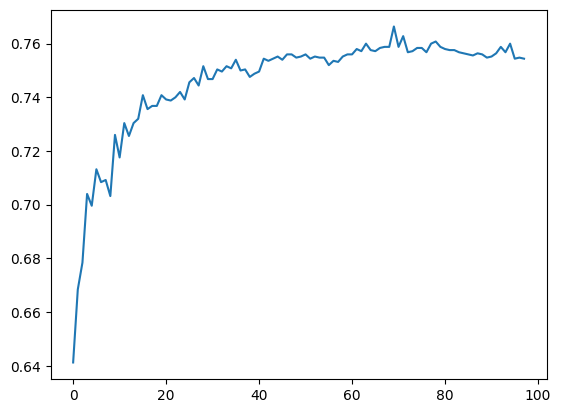

In [ ]:
# Create a Nearest Neighbors classifier with k
acc_list = []
for i in range(2,100):
  knn = KNeighborsClassifier(n_neighbors=i)

  # Fit the classifier to the training data
  knn.fit(x_train, y_train)

  # Predict the classes of the test set
  y_pred = knn.predict(x_test)

  # Calculate the accuracy of the classifier
  acc_list.append(accuracy_score(y_test, y_pred))
# print("Accuracy:", accuracy)
plt.plot(acc_list)

##SVM

In [ ]:
from sklearn.svm import SVC

# Create an SVM classifier with a Gaussian (RBF) kernel
svm_classifier = SVC(kernel='rbf', C=1, gamma='scale')

# Train the SVM classifier on the training data
svm_classifier.fit(x_train, y_train)


SVC(C=1)

In [ ]:
# Make predictions on the test data
y_pred = svm_classifier.predict(x_test)

# Calculate accuracy
accuracy = (y_test == torch.tensor(y_pred)).sum().item()/len(y_test)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 76.84%


##Model

In [ ]:
torch.manual_seed(5000000)

In [14]:
class DLGN(nn.Module):
    def __init__(self, dim_in, width, depth, beta):
        super().__init__()
        self.depth = depth
        self.width = width
        self.beta = beta
        self.gates = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width, bias=True) for i in range(self.depth)])
        self.weights = nn.ModuleList([nn.Linear(width, width, bias=False) for _ in range(self.depth)])
        self.weight_last = nn.Linear(width, 1, bias=False)
        self.dim_in = dim_in
        self.sigmoid = nn.Sigmoid()

    def ScaledSig(self,x):
        y = self.beta*x
        S = nn.Sigmoid()
        return S(y)

    def forward(self, x):
        g = x
        h = torch.ones(self.width).to(x.device)

        for i in range(self.depth):
            g = self.gates[i](g)
            h = self.ScaledSig(g) * self.weights[i](h)

        h_last = self.weight_last(h)
        return self.sigmoid(h_last)


In [15]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width,bias=False if i==0 else True) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return self.sigmoid(x)

## DataLoaders

In [16]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##Training DNN

In [17]:
model_dnn = DNN(18,1,500,4)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_dnn.parameters(), lr = learning_rate)

In [18]:
log_epochs = 10
num_epochs = 400
log_weight = 10

In [19]:
model_dnn.to(device)
Train_losses=[]
for epoch in range(num_epochs):
    model_dnn.train()
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model_dnn(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # if epoch % log_weight == 0:
    #     features_train.append(log_features(model_dnn))
    if epoch % log_epochs == 0:
        loss_full = loss_fn(model_dnn(x_train.to(device))[:,0],y_train.to(device))
        Train_losses.append(loss_full.item())
        print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
    if loss_full.item() < 0.001:
        print(f'Early stopping at epoch {epoch} because loss is below 0.01')
        break

Epoch 0 Loss 0.6929
Epoch 10 Loss 0.6554
Epoch 20 Loss 0.5485
Epoch 30 Loss 0.4462
Epoch 40 Loss 0.3546
Epoch 50 Loss 0.2573
Epoch 60 Loss 0.2241
Epoch 70 Loss 0.1342
Epoch 80 Loss 0.3243
Epoch 90 Loss 0.2695
Epoch 100 Loss 0.0095
Epoch 110 Loss 0.0026
Epoch 120 Loss 0.0015
Epoch 130 Loss 0.0010
Epoch 140 Loss 0.0008
Early stopping at epoch 140 because loss is below 0.01


In [20]:
test_loss_full = loss_fn(model_dnn(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.8780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [21]:
train_pred = model_dnn(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

1.0

In [22]:
test_pred = model_dnn(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.826

In [ ]:
test_pred

tensor([1.0000e+00, 9.9990e-01, 9.9929e-01,  ..., 9.9249e-01, 1.1053e-07,
        1.0000e+00], device='cuda:0', grad_fn=<SelectBackward0>)

Only features that are interpretable are first layer weights

In [ ]:
features_nn = model_dnn.layers[0].weight.clone().detach().to("cpu")

In [ ]:
feature_stats(features_nn,threshold=0.5)

array([0., 0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.])

##Logging Functions for DLGN

In [ ]:
def log_features(model,bias=False):
  weight = []
  bias = []
  for name, param in model.named_parameters():
      for i in range(0,4):
          if name == 'gates.'+str(i)+'.weight':
              weight.append(param.data)
          if bias:
            if name == 'gates.'+str(i)+'.bias':
                bias.append(param.data)

  Feature_list = [weight[0]]

  for w in weight[1:]:
    Feature_list.append(w @ Feature_list[-1])

  features = torch.cat(Feature_list, axis = 0).to("cpu")

  return features


def feature_stats(features,data_dim=18,tree_depth=4,dim_in=18,threshold=0.1,req_index=False): #can set tree_depth=0 to get root node stats...
  loss = nn.MSELoss()
  num_nodes = 2**tree_depth-1
  tensor = torch.eye(data_dim)
  y=torch.randn(dim_in)
  rand_point=y/torch.norm(y, p=2)

  count = np.zeros(num_nodes)
  index = [[]]*num_nodes
  for ind,item in enumerate(features):
      for i in range(num_nodes):
        if torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))-tensor[i]) < threshold or torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))+tensor[i]) < threshold:
            count[i] += 1
            if req_index:
              index[i].append(ind)
  if req_index:
    return count,index
  else:
    return count

## Training DLGN

In [ ]:
model = DLGN(dim_in,500,4,beta=4)
loss_fn = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
log_epochs = 10
num_epochs = 800
log_weight = 10

In [ ]:
features_initial = log_features(model)
features_train=[]

In [ ]:
model.to(device)
Train_losses=[]
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    if epoch % log_weight == 0:
        features_train.append(log_features(model))
    if epoch % log_epochs == 0:
        loss_full = loss_fn(model(x_train.to(device))[:,0],y_train.to(device))
        Train_losses.append(loss_full.item())
        print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
    if loss_full.item() < 0.01:
        print(f'Early stopping at epoch {epoch} because loss is below 0.01')
        break

features_final = log_features(model)

Epoch 0 Loss 0.6930
Epoch 10 Loss 0.6899
Epoch 20 Loss 0.6521
Epoch 30 Loss 0.6472
Epoch 40 Loss 0.6227
Epoch 50 Loss 0.5953
Epoch 60 Loss 0.5654
Epoch 70 Loss 0.5332
Epoch 80 Loss 0.5293
Epoch 90 Loss 0.4392
Epoch 100 Loss 0.4329
Epoch 110 Loss 0.3137
Epoch 120 Loss 0.3062
Epoch 130 Loss 0.2087
Epoch 140 Loss 0.1939
Epoch 150 Loss 0.1779
Epoch 160 Loss 0.1148
Epoch 170 Loss 0.0921
Epoch 180 Loss 0.0938
Epoch 190 Loss 0.0593
Epoch 200 Loss 0.0683
Epoch 210 Loss 0.0522
Epoch 220 Loss 0.0205
Epoch 230 Loss 0.0100
Epoch 240 Loss 0.0009
Early stopping at epoch 240 because loss is below 0.01


In [ ]:
test_loss_full = loss_fn(model(x_test.to(device))[:,0],y_test.to(device))
print(test_loss_full)

tensor(0.3838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
train_pred = model(x_train.to(device))[:,0]
thresh_pred = torch.where(train_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_train.to(device) == 0.0)

# Count the number of zeros
train_acc = zero_mask.sum().item()/len(y_train)
train_acc

1.0

In [ ]:
test_pred = model(x_test.to(device))[:,0]
thresh_pred = torch.where(test_pred < 0.5, torch.tensor(0), torch.tensor(1))
zero_mask = (thresh_pred-y_test.to(device) == 0.0)

# Count the number of zeros
test_acc = zero_mask.sum().item()/len(y_test)
test_acc

0.9292

## Empirical NPK

In [ ]:
from sklearn.svm import SVC


In [ ]:
def ScaledSig(x,beta=4.):
    y = beta*x
    S = nn.Sigmoid()
    return S(y)

def gate_score(model, x):
    g = x
    gate_scores = [x]
    for i in range(model.depth):
        g = model.gates[i](g)
        gate_scores.append(model.ScaledSig(g))
    return gate_scores

def compute_npk(U, V, model: torch.nn.Module) -> torch.Tensor:
  gate_scores1 = gate_score(model,U.to(device))
  gate_scores2 = gate_score(model,V.to(device))
  overlap_kernel = 1
  for i in range(1,len(gate_scores1)):
    el1 = gate_scores1[i].to(device)
    el2 = gate_scores2[i].to(device)
    overlap_kernel *= torch.matmul(el1,el2.T)
  return overlap_kernel.detach().cpu()

class NPK():
    """
    Class for NPK computation, designed to be used along with sklearn.svm.SVR/SVC
    """
    def __init__(self, model: torch.nn.Module) -> None:
      self.model = model

    def get_npk(self, U, V) -> torch.Tensor:
      return compute_npk(U, V, self.model)

In [ ]:
npk = NPK(model).get_npk

In [ ]:
svm_class = SVC(kernel= npk)

In [ ]:
svm_class.fit(x_train, y_train)

OutOfMemoryError: ignored

In [ ]:
y_pred = svm_class.predict(x_test)

# Calculate accuracy
accuracy = (y_test == torch.tensor(y_pred)).sum().item()/len(y_test)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 71.0%


##Stats

In [ ]:
features_initial

tensor([[-0.2176,  0.0550,  0.2306,  ...,  0.0976, -0.0872,  0.1674],
        [ 0.2023, -0.0958,  0.1069,  ...,  0.0896,  0.1183, -0.0426],
        [-0.1961,  0.0860, -0.0569,  ..., -0.1734,  0.1106,  0.1653],
        ...,
        [-0.0061, -0.0257, -0.0331,  ..., -0.0334, -0.0362, -0.0007],
        [-0.0391,  0.0192, -0.0226,  ..., -0.0120,  0.0185, -0.0021],
        [ 0.0291,  0.0127, -0.0027,  ...,  0.0062,  0.0339, -0.0319]])

Number of neurons clustering to nodes in the decision tree logged with the training iterations...

In [ ]:
print(feature_stats(features_initial))
for f in features_train:
  print(feature_stats(f))
print(feature_stats(features_final))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[17.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[19.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[24.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[23.  1.  2.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
[22.  1.  2.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.]
[21.  1.  2.  0.  0.  0.  0.  1.

Looking at the index of the neuron which cluster to the root node only...

In [ ]:
print(feature_stats(features_initial,tree_depth=1,req_index=True))
for f in features_train:
  print(feature_stats(f,tree_depth=1,req_index=True))
print(feature_stats(features_final,tree_depth=1,req_index=True))

(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([0.]), [[]])
(array([2.]), [[1261, 1522]])
(array([18.]), [[1261, 1522, 1572, 1614, 1626, 1646, 1652, 1688, 1713, 1766, 1768, 1818, 1831, 1865, 1920, 1945, 1960, 1978]])
(array([20.]), [[1261, 1522, 1572, 1614, 1626, 1646, 1652, 1688, 1705, 1713, 1766, 1768, 1818, 1831, 1865, 1915, 1920, 1945, 1960, 1978]])
(array([20.]), [[1261, 1522, 1572, 1626, 1646, 1652, 1688, 1713, 1766, 1814, 1818, 1831, 1865, 1894, 1915, 1920, 1929, 1945, 1960, 1978]])
(array([21.]), [[1261, 1522, 1572, 1614, 1626, 1646, 1652, 1688, 1705, 1713, 1766, 1814, 1818, 1865, 1894, 1915, 1920, 1929, 1945, 1960, 1978]])
(array([18.]), [[1261, 1522, 1572, 1614, 1626, 1646, 1652, 1688, 1713, 1766, 1814, 1818, 1865, 1894, 1915, 1920, 1945, 1960]])
(array([15.]), [[1261, 1522, 1572, 1614, 1626, 1646, 1688, 1705, 1713, 1818, 1865, 1915, 1920, 1945, 1960]])
(array([13.]), [[1261, 1

In [ ]:
len(features_initial)

2000

## Plotting

In [ ]:
def distance_calc(item,data_dim=18,node=0):
  tensor = torch.eye(data_dim)
  return min(torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))-tensor[node]),torch.linalg.vector_norm(item/(item.norm(dim=0, p=2))+tensor[node]))


def plot_neuron_dis(neuron,node=0,plot=True):
  fig, ax = plt.subplots()

  arr = []
  arr.append(distance_calc(features_initial[neuron],node=node))
  for f in features_train:
    arr.append(distance_calc(f[neuron],node=node))
  arr.append(distance_calc(features_final[neuron],node=node))

  if plot:
    ax.plot(range(len(arr[1:-1])),arr[1:-1], linewidth=1)
    ax.set_ylim(0,1.5)
    ax.hlines(y=0.1, xmin=0, xmax=19, linestyle='dotted', label='Horizontal Line')
  else:
    return arr[1:-1]

def plot_feature_dis(node=0,neuro_range=(1500,2000)):
  fig, ax = plt.subplots()
  for i in range(neuro_range[0],neuro_range[1]):
    arr = []
    arr.append(distance_calc(features_initial[i],node=node))
    for f in features_train:
      arr.append(distance_calc(f[i],node=node))
    arr.append(distance_calc(features_final[i],node=node))

    ax.plot(range(20),arr[1:-1], linewidth=0.3)


  ax.hlines(y=0.1, xmin=0, xmax=19, linestyle='dotted', label='Horizontal Line')

In [ ]:
torch.tensor([distance_calc(feat) for feat in features_initial[1000:1500]]).argmin()

tensor(167)

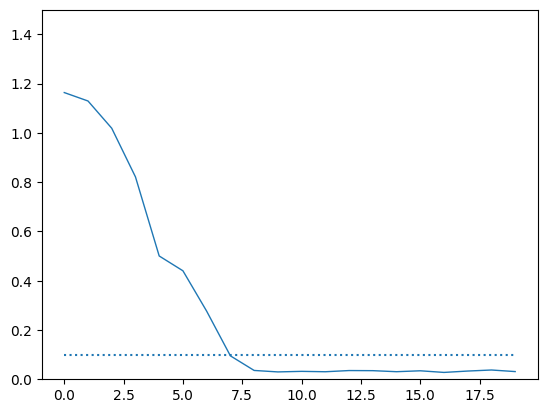

In [ ]:
plot_neuron_dis(1595)

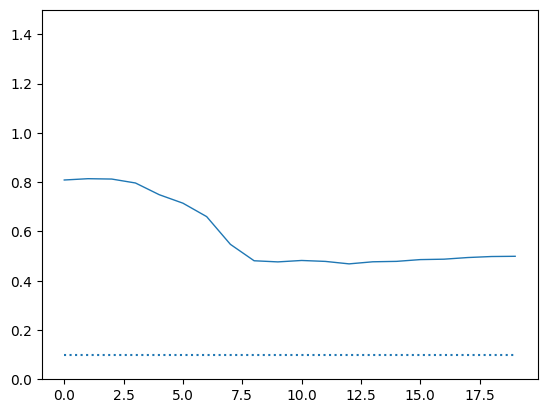

In [ ]:
plot_neuron_dis(608)

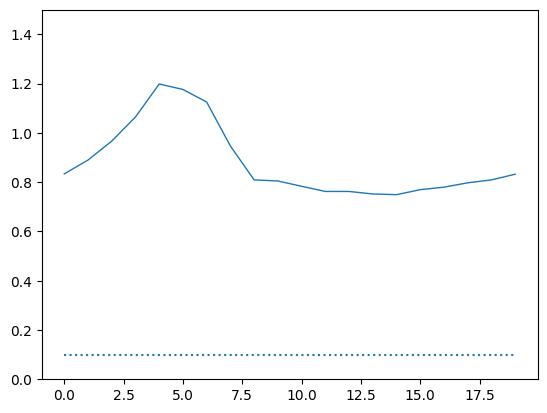

In [ ]:
plot_neuron_dis(1167)

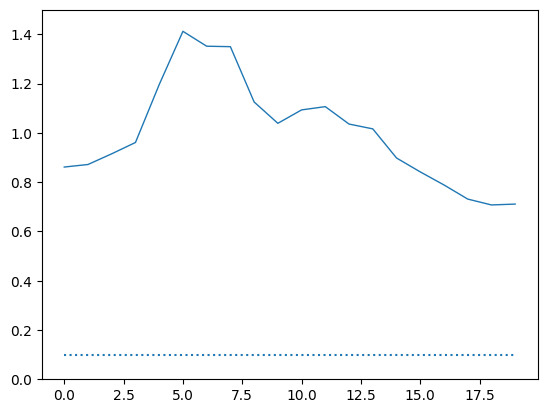

In [ ]:
plot_neuron_dis(1912)

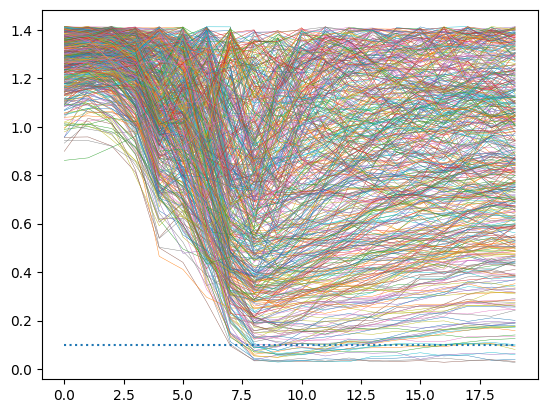

In [ ]:
plot_feature_dis()

4th Layer neurons clustering to root node

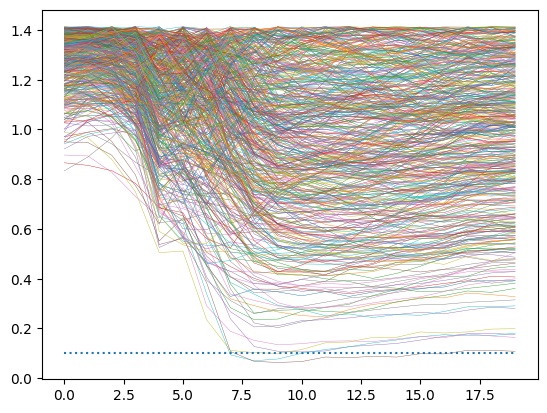

In [ ]:
plot_feature_dis(neuro_range=(1000,1500))

3rd layer

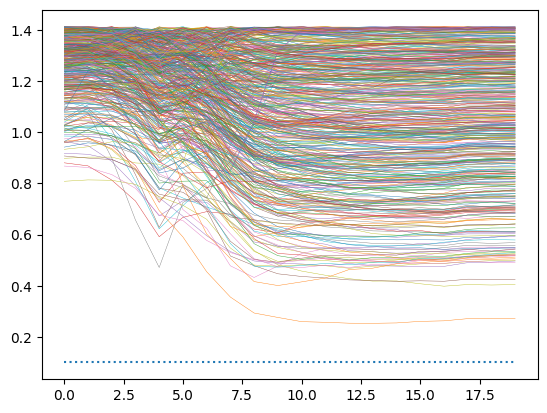

In [ ]:
plot_feature_dis(neuro_range=(500,1000))

2nd layer

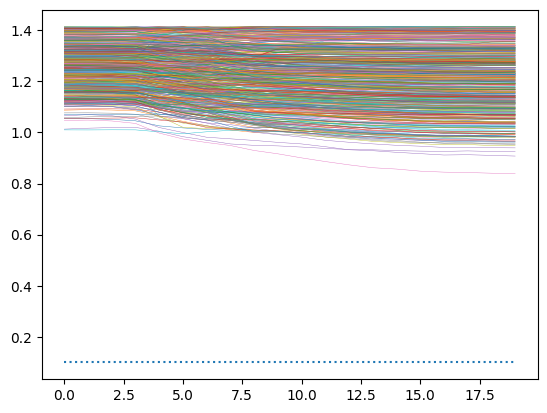

In [ ]:
plot_feature_dis(neuro_range=(0,500))

1st layer

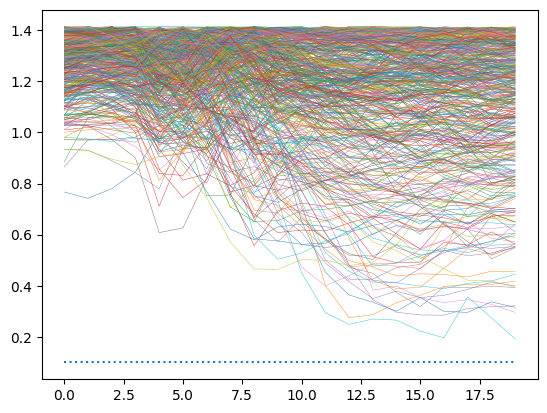

In [ ]:
plot_feature_dis(node=1)

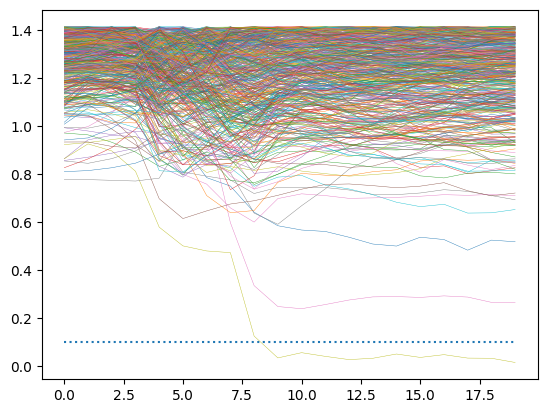

In [ ]:
plot_feature_dis(node=1,neuro_range=(1000,1500))

2nd layer node in Decision tree

In [ ]:
len(features_train)

20

## Model and feature saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/features_initial_32_0.01_log3.npy'

# Save the NumPy array to the specified file path
np.save(file_path,features_initial.numpy())

In [ ]:
np.array_equal(np.load('/content/drive/My Drive/features_initial_32_0.01_log3.npy'), features_initial.numpy())

True

In [ ]:
file_path = '/content/drive/My Drive/features_train_32_0.01_log3.npy'

# Save the NumPy array to the specified file path
for i in range(len(features_train)):
  np.save(file_path+'_'+str(i),features_train[i].numpy())

In [ ]:
for i in range(len(features_train)):
  print(np.array_equal(np.load('/content/drive/My Drive/features_train_32_0.01_log3.npy'+'_'+str(i)+'.npy'),features_train[i].numpy()))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
file_path = '/content/drive/My Drive/features_final_32_0.01_log3.npy'

# Save the NumPy array to the specified file path
np.save(file_path,features_final.numpy())

In [ ]:
np.array_equal(np.load('/content/drive/My Drive/features_final_32_0.01_log3.npy'), features_final.numpy())

True

In [ ]:
torch.save(model,'half_spaces_spherical_sgd_32_0.01_model4.pt')